In [92]:
%matplotlib inline
from imaka.analysis import plot_stats
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from imaka.analysis import add_data
root_dir = "/Users/fatimaabdurrahman/Desktop/Research/RUN5/20170521/FLI/"; stack_dir = root_dir + "reduce/stacks/"

# PSF Variability over Field of View

This preliminary analysis of PSF variability over the field of view shows no correlation between position on the field and either PSF size or elongation.  The plots below were generated from a stack of images from 20170518, with each data point representing one star in the stacked image.  The first set of four plots are open loop, and the second four are closed.

## Open Loop

/Users/fatimaabdurrahman/Desktop/Research/imaka/imaka/analysis/plot_stats.py:1352: RuntimeWarning: invalid value encountered in double_scalars
  elon.append(x_fwhm[i]/y_fwhm[i])


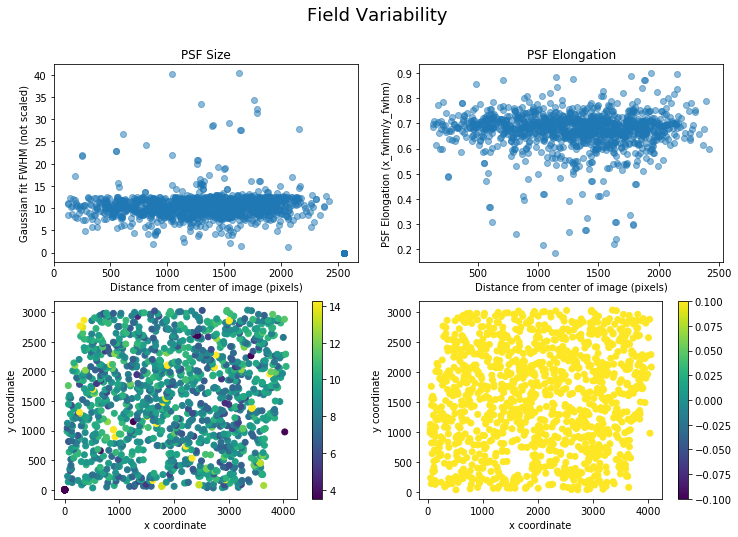

In [93]:
open_starlist = stack_dir+"FLD2_stack_open_stars.txt"; open_image = stack_dir + "FLD2_stack_open.fits" 
plot_stats.plot_field_var(open_starlist)


## Closed Loop

/Users/fatimaabdurrahman/Desktop/Research/imaka/imaka/analysis/plot_stats.py:1352: RuntimeWarning: invalid value encountered in double_scalars
  elon.append(x_fwhm[i]/y_fwhm[i])


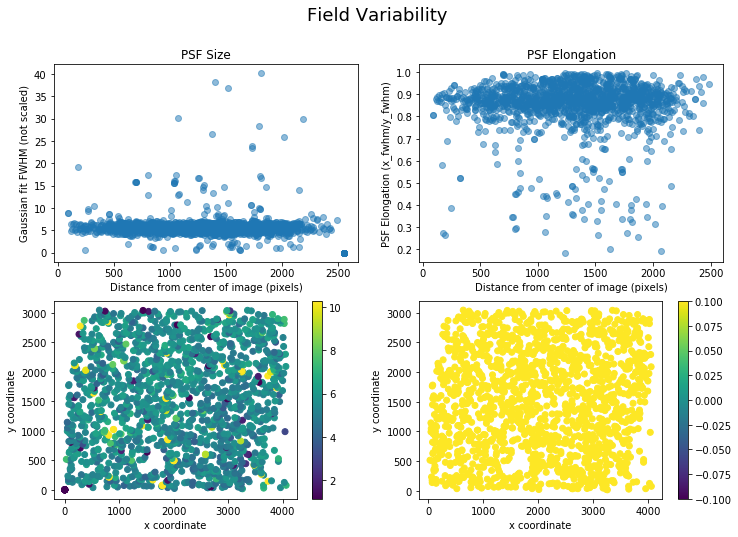

In [94]:
closed_starlist = stack_dir+"FLD2_stack_closed_stars.txt"; closed_image = stack_dir + "FLD2_stack_closed.fits"
plot_stats.plot_field_var(closed_starlist)

In [52]:
def emp_fwhm(starlist, image):
    img, hdr = fits.getdata(image, header=True)

    ###### calc emp_fwhm #####

    # Load up the corresponding starlist.
    stars = table.Table.read(starlist, format='ascii')
    N_stars = len(stars)


    emp_fwhm = np.zeros(N_stars, dtype=float)
    emp_fwhm_std = np.zeros(N_stars, dtype=float)

    bin_factor = hdr['BINFAC']
    band = 856
    plate_scale_orig = 0.04
    plate_scale = plate_scale_orig * bin_factor

    coords = np.array([stars['xcentroid'], stars['ycentroid']])

    # calculate emperical FWHM 
    emp_FWHM_list = np.zeros(N_stars, dtype=float)

    for jj in range(N_stars):
        # Make a 21x21 patch centered on centroid, oversample and interpolate
        x_cent = int(round(float(coords[0][jj])))
        y_cent = int(round(float(coords[1][jj])))
        if y_cent-10 > 0 and x_cent-10 > 0 and y_cent+10<np.shape(img)[0] and x_cent+10<np.shape(img)[1]:
            one_star = img[y_cent-10 : y_cent+10+1, x_cent-10 : x_cent+10+1]  # Odd box, with center in middle pixel.
            over_samp_5 = scipy.ndimage.zoom(one_star, 5, order = 1)

            # Find the pixels where the flux is a above half max value.
            max_flux = np.amax(over_samp_5) 
            half_max = max_flux / 2.0
            idx = np.where(over_samp_5 >= half_max)

            # Find the equivalent circle diameter for the area of pixels.
            #    Area = \pi * (FWHM / 2.0)**2
            area_count = len(idx[0]) / 5**2   # area in pix**2 -- note we went back to raw pixels (not oversampled)
            emp_FWHM = 2.0 * (area_count / np.pi)**0.5
            emp_FWHM_list[jj] = emp_FWHM

            # Find the median empirical FWHM of all stars. But first, trim to just the brightest stars.
    idx = np.where(stars['flux'] > 5)[0]
    if len(idx) == 0:
                # Didn't find any bright stars... use all of them.
        idx = np.arange(N_stars)
    emp_FWHM = (emp_FWHM_list[idx]) * ((band/500)**0.2) * plate_scale
    x_cents = coords[0][idx]
    y_cents = coords[1][idx]
    mean_FWHM = np.mean(emp_FWHM)
    std_FWHM = np.std(emp_FWHM)

    ##### calculating means at annuli #####
    field_cent_y, field_cent_x = np.array(np.shape(img))*0.5
    field_size_y, field_size_x = np.array(np.shape(img))

    radii  = np.arange(300, 3066/2, 50)
    means = np.zeros(len(radii), dtype=float)
    stds = np.zeros(len(radii), dtype=float)

    for ii in range(len(radii)):
        sizes = []
        for jj in range(len(idx)):
            if np.sqrt(((x_cents[jj]-field_cent_x)**2)+((y_cents[jj]-field_cent_y)**2)) < radii[ii]:
                sizes.append(emp_FWHM[jj])
        means[ii]=np.mean(sizes)
        stds[ii] =np.std(sizes)

    return radii, means, stds, emp_FWHM, x_cents, y_cents

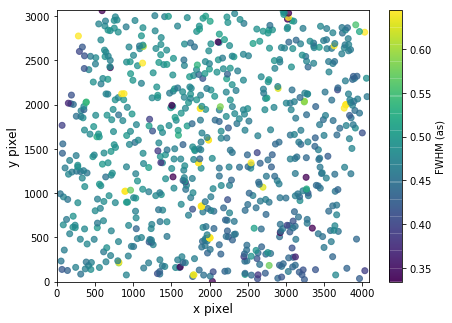

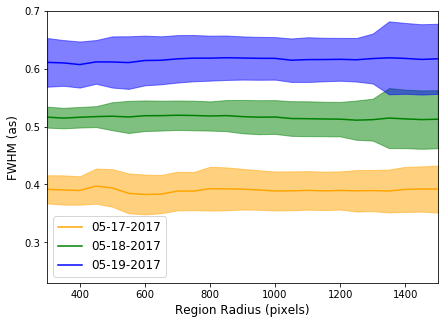

In [101]:
labels = [['20170517', 'FLD2_stack_closedA'] , ['20170518', 'FLD2_2_stack_closedA'], ['20170519', 'FLD2_2_stack_closedA'], \
 ['20170520', 'FLD2_2_stack_closedA'], ['20170521', 'FLD2_stack_closed']]
colors = ['Orange', 'g', 'b', 'Purple', 'k']

plt.figure(1, figsize=(7,5))
stack_dir = "/Users/fatimaabdurrahman/Desktop/Research/RUN5/20170521/FLI/reduce/stacks/"
starlist = stack_dir + "FLD2_stack_closed_stars.txt"
image = stack_dir + "FLD2_stack_closed.fits"
radii, means, stds, emp_FWHM, x_cents, y_cents = emp_fwhm(starlist, image)
plt.scatter(x_cents, y_cents, c=emp_FWHM, alpha=0.75, vmin=np.mean(emp_FWHM)-np.std(emp_FWHM), vmax=np.mean(emp_FWHM)+np.std(emp_FWHM))
plt.colorbar(label='FWHM (as)'); plt.xlabel('x pixel', fontsize=12); plt.ylabel('y pixel', fontsize=12)
plt.axis([0, 4088, 0, 3066])
plt.savefig('scatter.png')

plt.figure(2, figsize=(7,5))
for i in range(3):
    stack_dir = "/Users/fatimaabdurrahman/Desktop/Research/RUN5/" + labels[i][0] + "/FLI/reduce/stacks/"
    starlist = stack_dir + labels[i][1] + "_stars.txt"
    image = stack_dir + labels[i][1] + ".fits"
    radii, means, stds, emp_FWHM, x_cents, y_cents = emp_fwhm(starlist, image)
    #plt.subplot(5,1,i+1)
    plt.plot(radii, means, '-', markersize=5, color=colors[i], label = labels[i][0][4:6]+'-'+labels[i][0][6:]+'-'+labels[i][0][:4])
    plt.fill_between(radii, means-stds, means+stds, color=colors[i], alpha=0.5)
    #plt.ylim(means[-1]-.22, means[-1]+.26)
    #plt.ylabel(labels[i][0][4:6]+'-'+labels[i][0][6:]+'-'+labels[i][0][:4])
    #plt.tick_params(axis='x',  which='both', bottom='off', top='off', labelbottom='off')
plt.xlabel('Region Radius (pixels)', fontsize=12); plt.ylabel('FWHM (as)', fontsize=12)
plt.axis([300, max(radii), 0.23, 0.7])
plt.legend(loc=3, fontsize=12)
plt.savefig('variability.png')

In [2]:
import os
import math
import pylab as plt
import numpy as np
from astropy.io import fits
from astropy import table
from astropy import units
import pdb
#from astroscrappy import detect_cosmics
import glob
import photutils
from photutils import psf
from photutils import morphology as morph
from photutils import DAOStarFinder
from photutils import CircularAperture
from photutils import CircularAnnulus
from photutils import aperture_photometry
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.stats import sigma_clipped_stats
from astropy.modeling import models, fitting
from flystar import match
from flystar import align
from flystar import transforms
from imaka.reduce import calib
from imaka.reduce import util
#import ccdproc
from scipy.ndimage import interpolation
from scipy.ndimage import median_filter
import scipy.ndimage
from astropy.table import Table
from skimage.measure import block_reduce
from datetime import datetime
import pytz
